In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from importlib import reload

In [2]:
workers = 20
btch_sz = 4096
ws = 500
sr = 0.5
ngpu = 1

In [3]:
cuda = True if torch.cuda.is_available() else False
FloatTensor = torch.cuda.FloatTensor if cuda else torch.FloatTensor
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


# Data Preprocessing

In [4]:
def preproc(file, file_to_save):
    data = pd.read_csv(file)
    
    signal = torch.tensor(data.signal.values)
    signal = 2*(signal-signal.min())/(signal.max()-signal.min())-1
    
    data.signal = signal
    
    data.to_csv(file_to_save, index=False)

# preproc('data/train.csv', 'data/train_new.csv')
# preproc('data/test.csv', 'data/test_new.csv')

In [5]:
data = pd.read_csv('data/train.csv')
data_test = pd.read_csv('data/test.csv')

In [38]:
# data.iloc[:-100000].to_csv('data/train_new.csv', index=False)
data.iloc[2400000:2500000].to_csv('data/test_new.csv', index=False)

In [6]:
train_new = data.iloc[2000000:2400000]
train_new['open_channels_gessed'] = train_new.open_channels.values
rand_idx = np.random.choice(len(train_new), int(len(train_new)*0.4), replace=False)
train_new.open_channels_gessed.iloc[rand_idx] = -1
train_new.to_csv('data/train_new.csv', index=False)

In [7]:
test_new = data.iloc[2400000:2500000]
test_new['open_channels_gessed'] = test_new.open_channels.values
rand_idx = np.random.choice(len(test_new), int(len(test_new)*0.4), replace=False)
test_new.open_channels_gessed.iloc[rand_idx] = -1
test_new.to_csv('data/test_new.csv', index=False)

In [8]:
train_new

,time,signal,open_channels,open_channels_gessed
2000000,200.0001,7.1191,10,10
2000001,200.0002,6.7712,10,10
2000002,200.0003,6.9278,10,10
2000003,200.0004,7.3541,10,-1
2000004,200.0005,7.4194,10,10
...,...,...,...,...
2399995,239.9996,3.2503,7,-1
2399996,239.9997,2.9166,7,-1
2399997,239.9998,3.1316,7,-1
2399998,239.9999,3.0919,7,7


In [24]:
train_new.groupby(['open_channels_gessed']).count()

,time,signal,open_channels
open_channels_gessed,,,
-1,160000,160000,160000
1,28,28,28
2,239,239,239
3,1643,1643,1643
4,7105,7105,7105
5,21740,21740,21740
6,44649,44649,44649
7,63692,63692,63692
8,58856,58856,58856


In [10]:
n_unique = train_new.groupby(['open_channels_gessed']).count().open_channels.values[1:]
probs = n_unique/(len(train_new)-int(len(train_new)*0.4))
np.random.choice(10, 5, p=probs)

array([7, 6, 4, 6, 8])

<IPython.core.display.Javascript object>


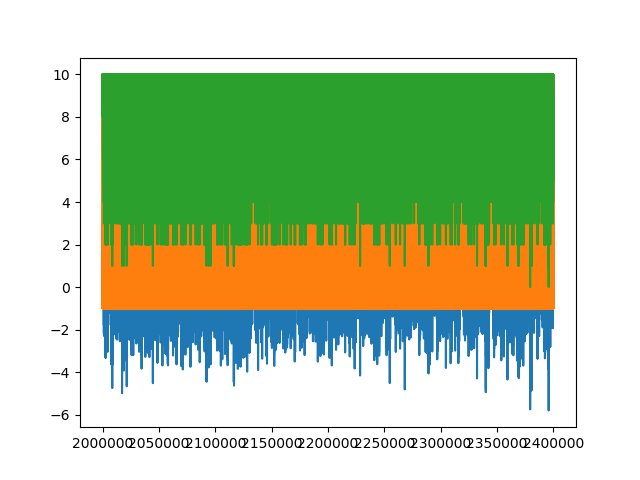

In [13]:
%matplotlib notebook
# plt.figure(figsize=(10,4))
plt.plot(train_new.signal)
plt.plot(train_new.open_channels_gessed)
plt.plot(train_new.open_channels)
plt.show()

In [38]:
data.loc[np.r_[:1000000, 1500000:len(data)]].to_csv('data/train_new.csv', index=False)
data.iloc[1000000:1500000].to_csv('data/test_new.csv', index=False)

<IPython.core.display.Javascript object>


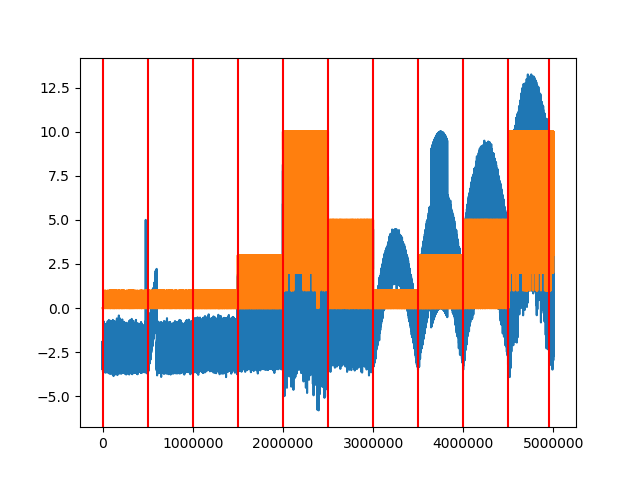

In [8]:
%matplotlib notebook
# plt.figure(figsize=(10,4))
plt.plot(data.signal)
plt.plot(data.open_channels)
plt.axvline(4950000, color='red')
for i in range(10):
    plt.axvline(500000*i, color='red')
plt.show()

<IPython.core.display.Javascript object>


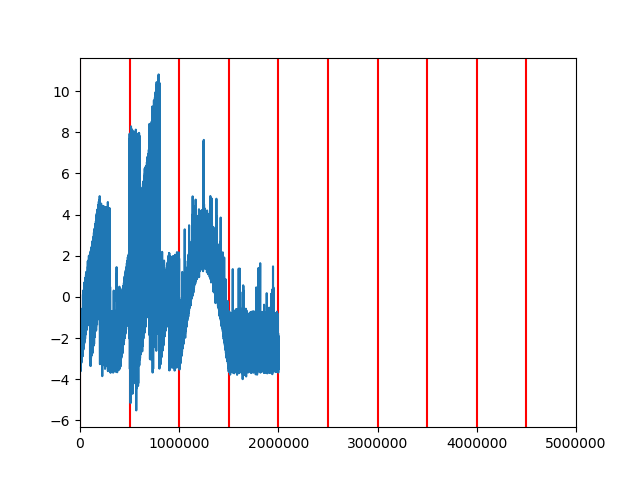

In [42]:
for i in range(10):
    plt.axvline(500000*i, color='red')
plt.xlim(0,5000000)
plt.plot(data_test.signal)
plt.show()

In [4]:
dev_0 = pd.read_csv('data/git_data/dev_1.csv')
dev_0.to_csv('data/test_new.csv', index=False)
dev_0

,s0,s1,s2,s3,signal,time,open_channels
0,8.4341,4.2585,0.0830,4.0926,-0.2472,397.0001,2
1,7.9389,3.7633,0.4123,4.5878,-0.3937,397.0002,2
2,7.7253,3.5497,0.6258,4.8014,-0.4569,397.0003,2
3,11.6296,7.4540,3.2784,0.8971,0.6979,397.0004,3
4,14.1960,10.0204,5.8448,1.6692,1.4569,397.0005,3
...,...,...,...,...,...,...,...
29995,3.5264,0.6492,4.8248,9.0004,-1.6987,399.9996,1
29996,8.0237,3.8481,0.3274,4.5030,-0.3686,399.9997,2
29997,9.9480,5.7724,1.5968,2.5787,0.2005,399.9998,2
29998,4.8021,0.6265,3.5491,7.7247,-1.3214,399.9999,1


In [5]:
train = pd.read_csv('data/git_data/train_1.csv')
train.to_csv('data/train_new.csv', index=False)
train

,s0,s1,s2,s3,signal,time,open_channels
0,11.2114,6.6767,2.1421,2.3926,0.3070,150.0001,3
1,13.5967,9.0620,4.5274,0.0073,0.9546,150.0002,3
2,14.5319,9.9972,5.4626,0.9279,1.2085,150.0003,3
3,14.5385,10.0039,5.4692,0.9346,1.2103,150.0004,3
4,14.3345,9.7998,5.2652,0.7305,1.1549,150.0005,3
...,...,...,...,...,...,...,...
499995,8.1476,3.6130,0.9217,5.4563,-0.5248,199.9996,2
499996,8.2382,3.7036,0.8311,5.3657,-0.5002,199.9997,2
499997,14.2704,9.7357,5.2011,0.6664,1.1375,199.9998,3
499998,11.0265,6.4918,1.9572,2.5775,0.2568,199.9999,2


In [5]:
test_0 = pd.read_csv('data/test_0.csv')
test_0.groupby(['batch']).count();
test_0

,time,signal,batch,p0,f0,p1,f1,s0,s1
0,500.0001,-2.651515,0.0,0.988266,0.926597,4.175389e-07,0.072753,0.015873,69.560891
1,500.0002,-2.851145,0.0,0.420159,0.926597,4.062301e-09,0.072753,0.870007,80.843595
2,500.0003,-2.861775,0.0,0.395406,0.926597,3.116443e-09,0.072753,0.917177,81.444361
3,500.0004,-2.436804,0.0,0.369412,0.926597,2.941934e-05,0.072753,0.968679,57.425801
4,500.0005,-2.617334,0.0,0.876618,0.926597,8.644177e-07,0.072753,0.167557,67.629008
...,...,...,...,...,...,...,...,...,...
99995,509.9996,-3.006308,0.0,0.148694,0.926597,7.047161e-11,0.072753,1.558563,89.613148
99996,509.9997,-3.152438,0.0,0.040852,0.926597,1.075222e-12,0.072753,2.207030,97.872129
99997,509.9998,-2.716668,0.0,0.800121,0.926597,9.892872e-08,0.072753,0.273248,73.243173
99998,509.9999,-2.278297,0.0,0.121301,0.926597,4.216439e-04,0.072753,1.672072,48.467270


In [25]:
a = np.array([1,2,3,4,5]).reshape(1, 5)
b = np.array([1,2,3,4,5]).reshape(1, 5)
c = np.empty((0,5))

In [26]:
c = np.append(c,b, axis=0)

In [27]:
np.append(c,a, axis=0)

array([[1., 2., 3., 4., 5.],
       [1., 2., 3., 4., 5.]])

# Format Dataloaders

In [4]:
from dataUtils.CustomDataset import IonSwitchingDataset

ion_dataset_train = IonSwitchingDataset('data/train_new.csv', window_size=ws, slice_ratio=sr)
ion_dataset_test = IonSwitchingDataset('data/test_new.csv', window_size=ws, slice_ratio=sr)
ion_dataset_submmit = IonSwitchingDataset('data/test.csv', window_size=ws, slice_ratio=sr, train=False)

In [5]:
dataloader = DataLoader(ion_dataset_train, batch_size=btch_sz, shuffle=True, num_workers=workers)
dataloader_test = DataLoader(ion_dataset_test, batch_size=25000, shuffle=False, num_workers=workers)
dataloader_submmit = DataLoader(ion_dataset_submmit, batch_size=btch_sz, shuffle=False, num_workers=workers)

In [6]:
batch = next(iter(dataloader))

In [7]:
batch['input'].shape, batch['open_channels'].shape

(torch.Size([4096, 5, 501]), torch.Size([4096, 11]))

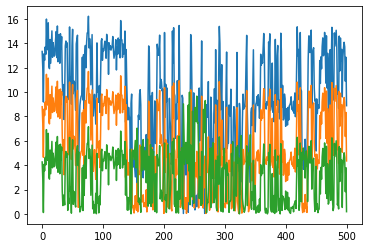

In [8]:
%matplotlib inline
plt.plot(batch['input'][0][0])
plt.plot(batch['input'][0][1])
plt.plot(batch['input'][0][2])
plt.show()

# Load Model

In [24]:
import models.FCC as FCC
reload(FCC)

model = FCC.OpenChannelsClassifier(1)
model.apply(FCC.weights_init)
print(sum(p.numel() for p in model.parameters()))
model.to(device)
model = torch.nn.DataParallel(model)

16733763


In [18]:
model(batch['input'].to(device).float().view(btch_sz, 5, ws+1)).shape

RuntimeError: shape '[4096, 5, 501]' is invalid for input of size 721440

In [ ]:
512*12

# Optimirez and Criterion Loss

In [25]:
lr = 0.001
# lr = 0.01
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
# optimizer = torch.optim.SGD(model.parameters(), lr=lr)

In [26]:
train_losses = np.array([])
train_accurasy = np.array([])
train_f1 = np.array([])
test_accurasy = np.array([])
test_f1 = np.array([])

In [27]:
batch_test = next(iter(dataloader_test))

# Training Loop

In [28]:
from sklearn.metrics import f1_score

num_epochs = 3
monit_res = 5
for epoch in range(num_epochs):

    running_loss = 0.0
    for i, batch in enumerate(dataloader):
        model.train()
        optimizer.zero_grad()
        
        input, labels = batch['input'], batch['open_channels']
        input = input.to(device).float().view(len(input), 5, ws+1)
        labels = labels.to(device).float()
        
#         open_channels = batch['open_channels_gessed']
#         open_channels = open_channels.to(device).float().view(len(open_channels), 1, ws+1)
#         n_gessed = len(open_channels[open_channels == -1])
#         open_channels[open_channels == -1] = torch.cuda.FloatTensor(np.random.choice(10, n_gessed, p=probs))
    
    
        output = model(input)
        
        loss = criterion(output, torch.max(labels, 1)[1])
        loss.backward()
        optimizer.step()        
        
        running_loss += loss.item()
        
        
        if i%monit_res == monit_res-1:
            model.eval()
            predicted_idx = torch.max(output, 1)[1]
            true_idx = torch.max(labels, 1)[1]
            predicted_idx = predicted_idx.cpu().detach()
            true_idx = true_idx.cpu().detach()
            accurasy = sum(true_idx == predicted_idx).item()/len(true_idx)     
            f1 = f1_score(true_idx, predicted_idx, average='macro')
            train_accurasy = np.append(train_accurasy, accurasy)
            train_f1 = np.append(train_f1, f1)
            
            t_accurasy = 0
            t_f1 = 0
            
            input, labels = batch_test['input'], batch_test['open_channels']
            input = input.to(device).float().view(len(batch_test['input']), 5, ws+1)
            labels = labels.to(device).float()

#             open_channels = batch['open_channels_gessed']
#             open_channels = open_channels.to(device).float().view(len(open_channels), 1, ws+1)
#             n_gessed = len(open_channels[open_channels == -1])
#             open_channels[open_channels == -1] = torch.cuda.FloatTensor(np.random.choice(10, n_gessed, p=probs))

            output = model(input)
            predicted_idx = torch.max(output, 1)[1]
            true_idx = torch.max(labels, 1)[1]
            predicted_idx = predicted_idx.cpu().detach()
            true_idx = true_idx.cpu().detach()
            t_accurasy = sum(true_idx == predicted_idx).item()/len(true_idx)     
            t_f1 = f1_score(true_idx, predicted_idx, average='macro')
            test_accurasy = np.append(test_accurasy, t_accurasy)
            
            test_f1 = np.append(test_f1, t_f1)

            
            train_losses = np.append(train_losses, running_loss/monit_res)
            print('[{}/{}] [{}/{}], loss: {}, accyrasy: {}, f1: {}'.format(epoch,
                                                     num_epochs,
                                                     i,
                                                     len(dataloader),
                                                     round(running_loss/monit_res, 4),
                                                     round(accurasy, 4),
                                                     f1
                                                    )
                 )
            running_loss = 0.0

[0/3] [4/123], loss: 1.4001, accyrasy: 0.5842, f1: 0.32029550941574125
[0/3] [9/123], loss: 0.8188, accyrasy: 0.6594, f1: 0.43629536447290396
[0/3] [14/123], loss: 0.5903, accyrasy: 0.804, f1: 0.5691072223473984
[0/3] [19/123], loss: 0.4034, accyrasy: 0.8938, f1: 0.6523323149606233
[0/3] [24/123], loss: 0.2673, accyrasy: 0.9502, f1: 0.7131292402872886
[0/3] [29/123], loss: 0.1689, accyrasy: 0.96, f1: 0.7655628616152648
[0/3] [34/123], loss: 0.1156, accyrasy: 0.9688, f1: 0.8182997841071729
[0/3] [39/123], loss: 0.0919, accyrasy: 0.9697, f1: 0.8514320044177929
[0/3] [44/123], loss: 0.0812, accyrasy: 0.9683, f1: 0.8995817207744495
[0/3] [49/123], loss: 0.069, accyrasy: 0.9773, f1: 0.9399519999743581
[0/3] [54/123], loss: 0.0663, accyrasy: 0.9771, f1: 0.915282870767504
[0/3] [59/123], loss: 0.0611, accyrasy: 0.979, f1: 0.9253466520283907
[0/3] [64/123], loss: 0.0544, accyrasy: 0.9807, f1: 0.9629039380432863
[0/3] [69/123], loss: 0.0506, accyrasy: 0.9854, f1: 0.976513590047869
[0/3] [74/123

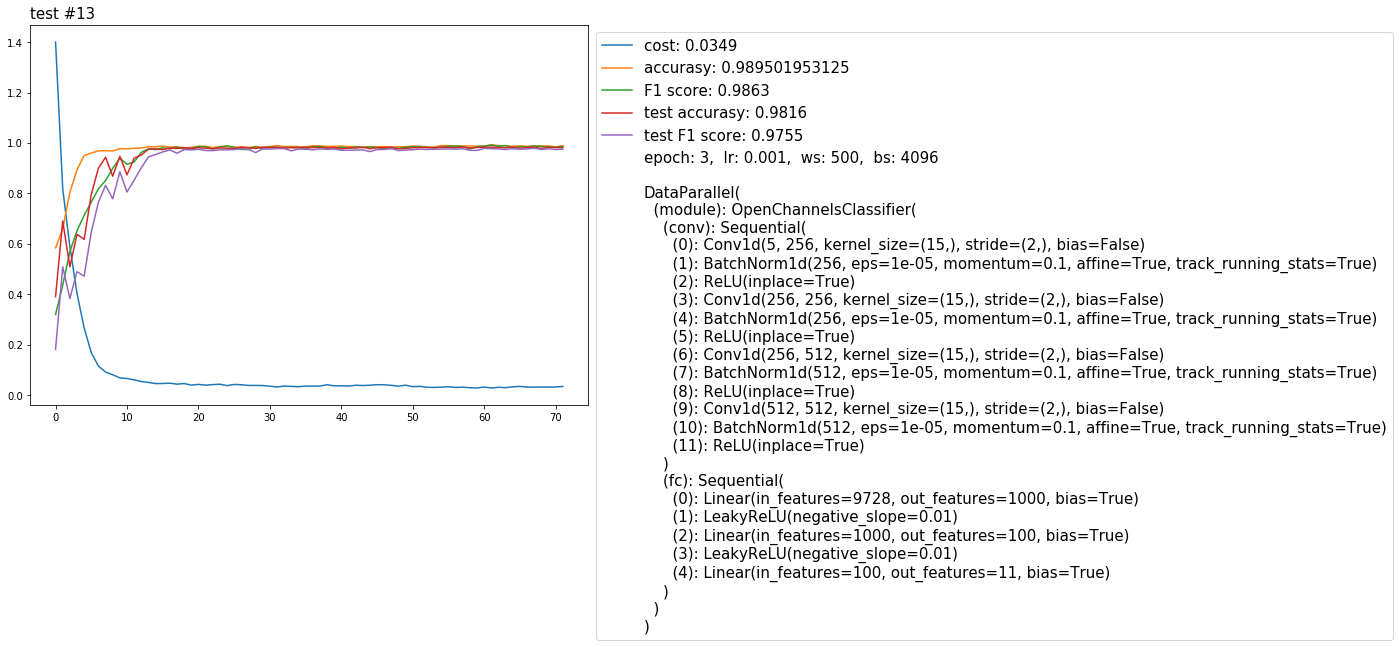

In [29]:
%matplotlib inline
plt.figure(figsize=(10,7))
plt.plot(train_losses, label='cost: {}'.format(round(train_losses[-1], 4)))
plt.plot(train_accurasy, label='accurasy: {}'.format(accurasy))
plt.plot(train_f1, label='F1 score: {}'.format(round(train_f1[-1], 4)))
plt.plot(test_accurasy, label='test accurasy: {}'.format(t_accurasy))
plt.plot(test_f1, label='test F1 score: {}'.format(round(test_f1[-1], 4)))
plt.plot([], [], ' ', label="epoch: {},  lr: {},  ws: {},  bs: {}\n\n{}".format(num_epochs, lr, ws, btch_sz, model))
plt.title('test #13', fontsize=15, loc='left')
plt.legend(fontsize=15, bbox_to_anchor=(1, 1))
plt.show()

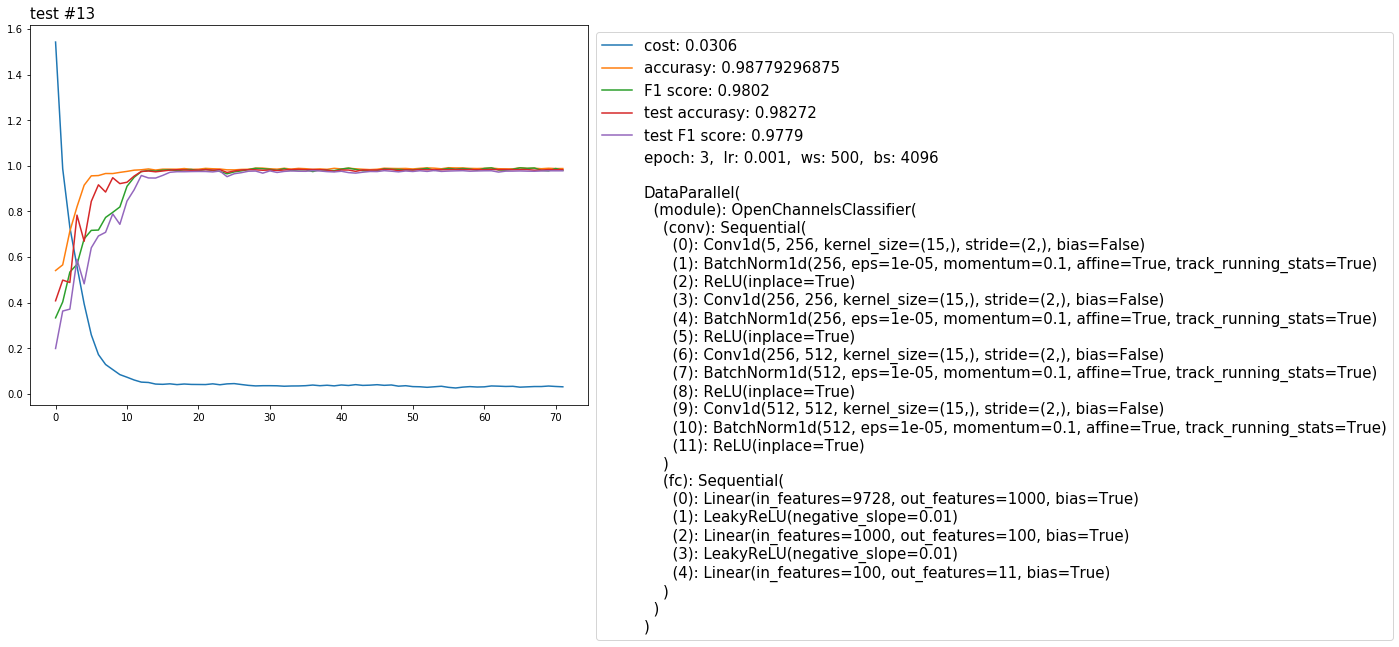

In [23]:
%matplotlib inline
plt.figure(figsize=(10,7))
plt.plot(train_losses, label='cost: {}'.format(round(train_losses[-1], 4)))
plt.plot(train_accurasy, label='accurasy: {}'.format(accurasy))
plt.plot(train_f1, label='F1 score: {}'.format(round(train_f1[-1], 4)))
plt.plot(test_accurasy, label='test accurasy: {}'.format(t_accurasy))
plt.plot(test_f1, label='test F1 score: {}'.format(round(test_f1[-1], 4)))
plt.plot([], [], ' ', label="epoch: {},  lr: {},  ws: {},  bs: {}\n\n{}".format(num_epochs, lr, ws, btch_sz, model))
plt.title('test #13', fontsize=15, loc='left')
plt.legend(fontsize=15, bbox_to_anchor=(1, 1))
plt.show()

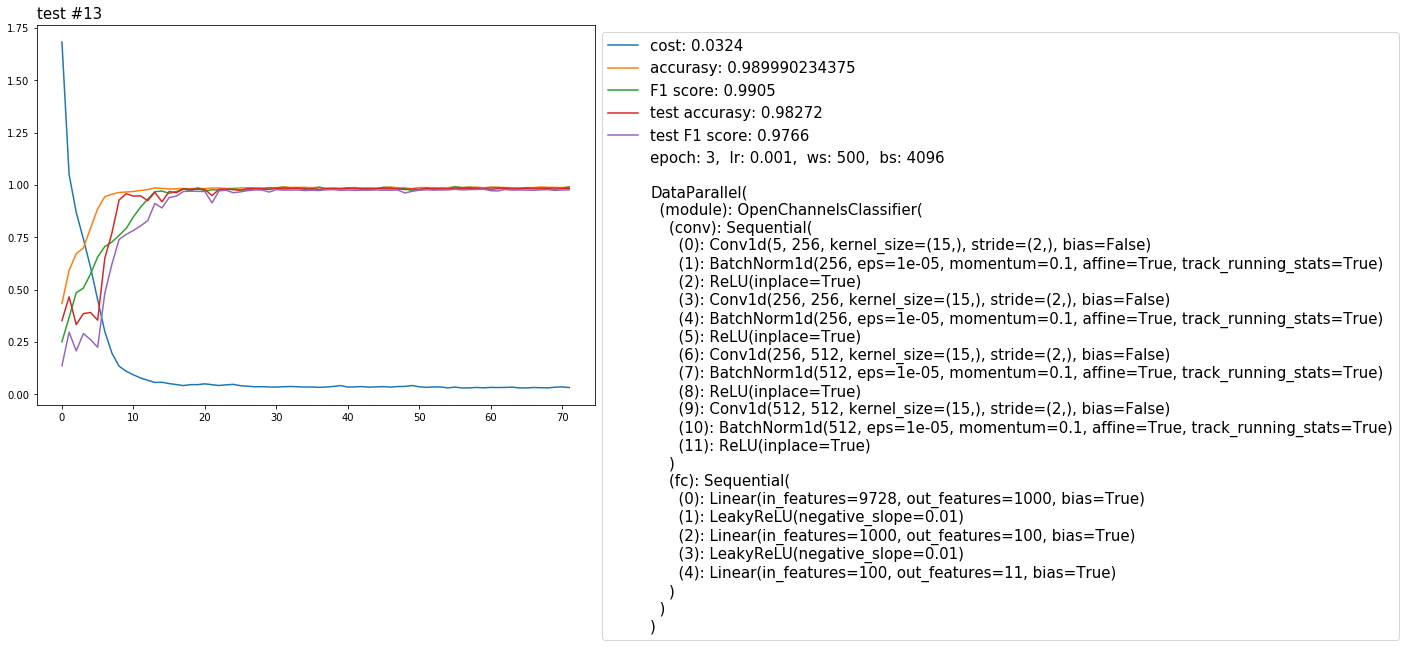

In [16]:
%matplotlib inline
plt.figure(figsize=(10,7))
plt.plot(train_losses, label='cost: {}'.format(round(train_losses[-1], 4)))
plt.plot(train_accurasy, label='accurasy: {}'.format(accurasy))
plt.plot(train_f1, label='F1 score: {}'.format(round(train_f1[-1], 4)))
plt.plot(test_accurasy, label='test accurasy: {}'.format(t_accurasy))
plt.plot(test_f1, label='test F1 score: {}'.format(round(test_f1[-1], 4)))
plt.plot([], [], ' ', label="epoch: {},  lr: {},  ws: {},  bs: {}\n\n{}".format(num_epochs, lr, ws, btch_sz, model))
plt.title('test #13', fontsize=15, loc='left')
plt.legend(fontsize=15, bbox_to_anchor=(1, 1))
plt.show()

In [45]:
def save(model, epoch, loss, path_to_save):
    torch.save({
                'model': model.module.state_dict(),
                'epoch': epoch,
                'loss': loss,
                },
                path_to_save)


In [68]:
save(model=model, epoch=15, loss=np.array([train_losses,train_accurasy]), path_to_save='one_channel.pth' )

# Prediction

In [28]:
checkpoint = torch.load('chechpoit.pth')
model = FCC.OpenChannelsClassifier(1)
model.load_state_dict(checkpoint['model'])
model.to(device)
model = torch.nn.DataParallel(model)

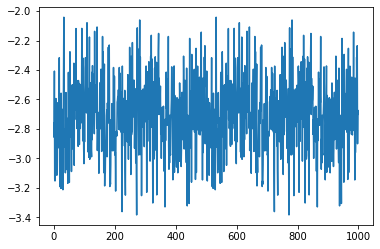

In [13]:
plt.plot(next(iter(dataloader_test))['signal'][0])
plt.show()

In [30]:
model.eval()
prediction = torch.tensor([]).to(device)
for i, batch in enumerate(dataloader_test):
    
    signal = batch['signal']
    open_channels = batch['open_channels_gessed']
    signal = signal.to(device).float().view(len(batch['signal']), 1, ws+1)
    
    open_channels = open_channels.to(device).float().view(len(open_channels), 1, ws+1)
    n_gessed = len(open_channels[open_channels == -1])
    open_channels[open_channels == -1] = torch.cuda.FloatTensor(np.random.choice(10, n_gessed, p=probs))
    
    with torch.no_grad():
        output = model(signal, open_channels)
  
    
    predicted_idx = torch.max(output, 1)[1]
    prediction = torch.cat((prediction, predicted_idx.float()), 0)
    
    if i%50 == 49:
        print('[{}/{}]'.format(i, len(dataloader_test)))

[49/98]


In [31]:
prediction = prediction.cpu().detach().numpy()

In [207]:
np.save('prediction/prediction', prediction)

In [32]:
data_test = pd.read_csv('data/test_new.csv')

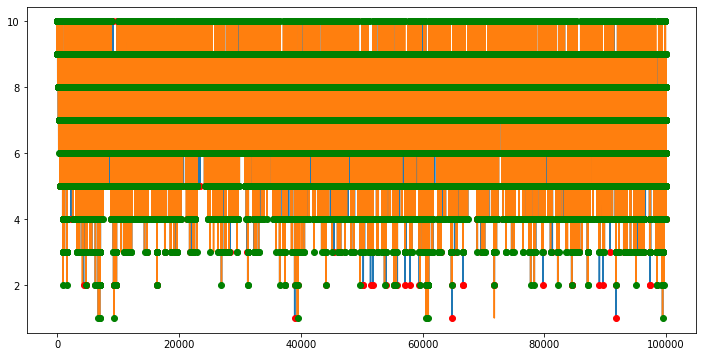

In [33]:
true_indx = data_test.index[prediction == data_test.open_channels.values]
false_indx = data_test.index[prediction != data_test.open_channels.values]
true_data = data_test.open_channels.values[prediction == data_test.open_channels.values]
false_data = data_test.open_channels.values[prediction != data_test.open_channels.values]

%matplotlib inline
plt.figure(figsize=(12,6))
plt.plot(data_test.open_channels.values)
plt.plot(prediction)
plt.plot(false_indx, false_data, lw=0, marker='o', color='red')
plt.plot(true_indx, true_data, lw=0, marker='o', color='green')
plt.show()

In [34]:
sum(prediction == data_test.open_channels.values)/len(prediction)

0.85565

In [35]:
f1_score(data_test.open_channels.values, prediction, average='macro')

0.8277416500574019

In [86]:
f1_score(data_test.open_channels.values, prediction, average='macro')

0.8766584256391609

In [104]:
f1_score(data_test.open_channels.values, prediction, average='macro')

0.7930047560080558